In [ ]:
from S2GD import S2GD
from utils import *
from Regpb import L2regLS
import numpy as np 
from scipy.linalg import norm 
import time

In [5]:
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,with_replace=False,verbose=True,fast=False,adapting_step=False,patience=3,tolerance_adapt=1e-3): 
    """
        Stochastic gradient descent.
        
        Inputs:
            x0: Initial vector
            problem
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                <0: Step size decreasing in 1/(k+1)**t
                >0: Constant step size equal to step
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            fast: Boolean indicating whether we want to compute info every iteration or only of "one pass on the data"
            
        Outputs:
            x_output: Final iterate of the method 
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
            nbgradcomp : History of number of gradient evaluated at every iteration
    """
    objvals = []
    normits = []
    times = [0]
    nb_grap_comp = [0]

    L = problem.lipgrad()
    n = problem.n
    x = x0.copy()
    nx = norm(x)


    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj)

    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    start_time = time.time()
    if verbose:
        # Display initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(problem.d)
        for j in range(nb):
            gi = problem.grad_i(x,ik[j])
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - step0 * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        
        k += 1

        nx = norm(x) #Computing the norm to measure divergence 

        if not(fast):
            obj = problem.fun(x)
            nmin = norm(x-xtarget)
            objvals.append(obj)
            end_time = time.time()
            times.append(end_time - start_time)
            nb_grap_comp.append(k*nb)
            normits.append(nmin)

            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)])) 
        else:
            if (k*nb) % n == 0:
                obj = problem.fun(x)
                nmin = norm(x-xtarget)
                objvals.append(obj)
                end_time = time.time()
                times.append(end_time - start_time)
                nb_grap_comp.append(k*nb)
                normits.append(nmin)

                if verbose:
                    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))  

        if adapting_step:
            if ((k*nb) % n == 0 or not(fast)) and step0 > 1e-6:
                if len(objvals) > patience:
                    recent_objvals = objvals[-patience:]
                    relative_change = np.abs(recent_objvals[-1] - recent_objvals[0]) / np.abs(recent_objvals[0])
                    if relative_change < tolerance_adapt:
                        stagnation_counter += 1
                        if stagnation_counter >= patience:
                            step0 /= 2  
                            stagnation_counter = 0  
                            tolerance_adapt /= 2 
                            if verbose:
                                print(f"Reducing step size to {step0:.2e} due to stagnation.")
                    else:
                        stagnation_counter = 0  


    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        end_time = time.time()
        times.append(end_time - start_time)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits), nb_grap_comp, times

In [6]:
d = int(50)
n = int(25000)
lbda = 1. / n ** (0.5)
#lbda = 0
kappa = 1e3

np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = generate_sparse_x(d,sparsity=0.1)

A, y = generate_pb_parameters(x_model_truth, n, d, kappa,lbda, std=0, corr=0.7)
ylog = np.sign(y) # Taking the logarithm for binary classification
yone = np.copy(ylog)
yone[ylog==-1] = 0 
x0 = np.random.randn(d)
pbL2reg = L2regLS(A,y,lbda,'l2')

print(pbL2reg.fun(x_model_truth))

0.01739034982126003


In [7]:
x_sgd,obj_val_sgd,_,nb_comp_grad_sgd, times1 = stoch_grad(x0=x0,problem=pbL2reg,xtarget=x_model_truth,stepchoice=0,step0=3e-3/pbL2reg.lipgrad(), n_iter=3*1e6,nb=1,with_replace=False,verbose=True,fast=True)

Stochastic Gradient, batch size= 1 / 25000
  iter   |   fval   |  normit 
       0 | 7.17e+01 | 7.41e+00
   25000 | 6.62e-02 | 2.06e+00
   50000 | 3.78e-02 | 1.67e+00
   75000 | 2.99e-02 | 1.43e+00
  100000 | 2.60e-02 | 1.25e+00
  125000 | 2.36e-02 | 1.10e+00
  150000 | 2.20e-02 | 9.76e-01
  175000 | 2.09e-02 | 8.68e-01
  200000 | 2.01e-02 | 7.75e-01
  225000 | 1.95e-02 | 6.93e-01
  250000 | 1.91e-02 | 6.20e-01
  275000 | 1.87e-02 | 5.56e-01
  300000 | 1.84e-02 | 4.99e-01
  325000 | 1.82e-02 | 4.49e-01
  350000 | 1.80e-02 | 4.03e-01
  375000 | 1.79e-02 | 3.63e-01
  400000 | 1.78e-02 | 3.28e-01
  425000 | 1.77e-02 | 2.96e-01
  450000 | 1.76e-02 | 2.68e-01
  475000 | 1.76e-02 | 2.43e-01
  500000 | 1.75e-02 | 2.21e-01
  525000 | 1.75e-02 | 2.01e-01
  550000 | 1.75e-02 | 1.84e-01
  575000 | 1.74e-02 | 1.68e-01
  600000 | 1.74e-02 | 1.55e-01
  625000 | 1.74e-02 | 1.42e-01
  650000 | 1.74e-02 | 1.32e-01
  675000 | 1.74e-02 | 1.22e-01
  700000 | 1.74e-02 | 1.14e-01
  725000 | 1.74e-02 | 1.06e

In [8]:
x_sgd_adapt,obj_val_sgd_adapt,_,nb_comp_grad_sgd_adapt, times2 = stoch_grad(x0=x0,problem=pbL2reg,xtarget=x_model_truth,stepchoice=0,step0=3e-3/pbL2reg.lipgrad(), n_iter=3*1e6,nb=1,with_replace=False,verbose=True,fast=True,adapting_step=True,patience=5,tolerance_adapt=1e-4)

Stochastic Gradient, batch size= 1 / 25000
  iter   |   fval   |  normit 
       0 | 7.17e+01 | 7.41e+00
   25000 | 6.52e-02 | 2.05e+00
   50000 | 3.77e-02 | 1.67e+00
   75000 | 2.98e-02 | 1.43e+00
  100000 | 2.59e-02 | 1.25e+00
  125000 | 2.35e-02 | 1.10e+00
  150000 | 2.20e-02 | 9.75e-01
  175000 | 2.09e-02 | 8.67e-01
  200000 | 2.01e-02 | 7.74e-01
  225000 | 1.95e-02 | 6.92e-01
  250000 | 1.91e-02 | 6.19e-01
  275000 | 1.87e-02 | 5.55e-01
  300000 | 1.84e-02 | 4.98e-01
  325000 | 1.82e-02 | 4.48e-01
  350000 | 1.80e-02 | 4.03e-01
  375000 | 1.79e-02 | 3.63e-01
  400000 | 1.78e-02 | 3.28e-01
  425000 | 1.77e-02 | 2.96e-01
  450000 | 1.76e-02 | 2.68e-01
  475000 | 1.76e-02 | 2.43e-01
  500000 | 1.75e-02 | 2.21e-01
  525000 | 1.75e-02 | 2.01e-01
  550000 | 1.75e-02 | 1.84e-01
  575000 | 1.74e-02 | 1.68e-01
  600000 | 1.74e-02 | 1.55e-01
  625000 | 1.74e-02 | 1.42e-01
  650000 | 1.74e-02 | 1.32e-01
  675000 | 1.74e-02 | 1.22e-01
  700000 | 1.74e-02 | 1.14e-01
  725000 | 1.74e-02 | 1.06e

In [9]:
from plot_iterations import *
nb_gradients = [nb_comp_grad_sgd, nb_comp_grad_sgd_adapt]
obj_functions = [obj_val_sgd, obj_val_sgd_adapt]
name_of_models = ['SGD', 'SGD_adapt']
list_times = [times1 , times2]

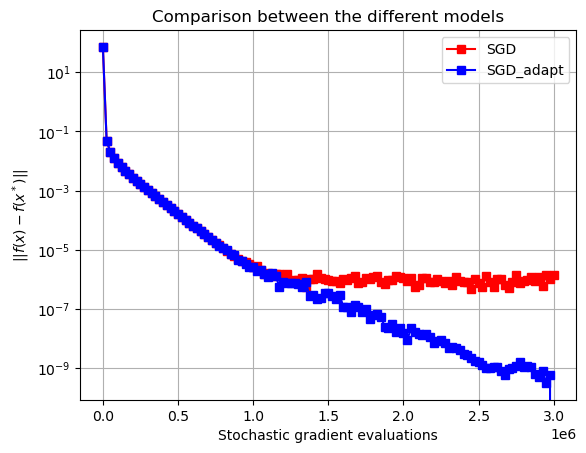

In [10]:
plot_with_nb_gradients(nb_gradients=nb_gradients,obj_functions=obj_functions,name_of_models=name_of_models)

In [31]:
def stoch_grad_sched(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,with_replace=False,verbose=True,fast=False,adapting_step=False,patience=3,tolerance_adapt=1e-3): 
    """
        Stochastic gradient descent.
        
        Inputs:
            x0: Initial vector
            problem
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                <0: Step size decreasing in 1/(k+1)**t
                >0: Constant step size equal to step
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            fast: Boolean indicating whether we want to compute info every iteration or only of "one pass on the data"
            
        Outputs:
            x_output: Final iterate of the method 
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
            nbgradcomp : History of number of gradient evaluated at every iteration
    """
    objvals = []
    normits = []
    times = [0]
    nb_grap_comp = [0]

    L = problem.lipgrad()
    n = problem.n
    x = x0.copy()
    nx = norm(x)


    k=0
    cycle = 0
    schedule = False
    already = False

    eta_max = step0
    eta_min = 1e-6
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj)

    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    start_time = time.time()
    if verbose:
        # Display initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(problem.d)
        for j in range(nb):
            gi = problem.grad_i(x,ik[j])
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - step0 * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        
        k += 1

        nx = norm(x) #Computing the norm to measure divergence 

        if not(fast):
            obj = problem.fun(x)
            nmin = norm(x-xtarget)
            objvals.append(obj)
            end_time = time.time()
            times.append(end_time - start_time)
            nb_grap_comp.append(k*nb)
            normits.append(nmin)

            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)])) 
        else:
            if (k*nb) % n == 0:
                obj = problem.fun(x)
                nmin = norm(x-xtarget)
                objvals.append(obj)
                end_time = time.time()
                times.append(end_time - start_time)
                nb_grap_comp.append(k*nb)
                normits.append(nmin)

                if verbose:
                    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))  

        if adapting_step:
            if ((k*nb) % n == 0 or not(fast)) and not(already):
                if len(objvals) > patience:
                    recent_objvals = objvals[-patience:]
                    relative_change = np.abs(recent_objvals[-1] - recent_objvals[0]) / np.abs(recent_objvals[0])
                    if relative_change < tolerance_adapt:
                        stagnation_counter += 1
                        if stagnation_counter >= patience:
                            schedule = True
                            already = True
                            if verbose:
                                print(f"Scheduler due to stagnation.")
                    else:
                        stagnation_counter = 0  
            if ((k*nb) % n == 0 and already):
                cycle += 1
            if ((k*nb) % n == 0 and schedule):
                step0 = eta_min + (eta_max - eta_min) * (1 + np.cos(np.pi * cycle / patience)) / 2
                print('step=',step0)
                if cycle == patience :
                    cycle = 0 



    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        end_time = time.time()
        times.append(end_time - start_time)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits), nb_grap_comp, times

In [32]:
x_sgd_sched,obj_val_sgd_sched,_,nb_comp_grad_sgd_sched, times3 = stoch_grad_sched(x0=x0,problem=pbL2reg,xtarget=x_model_truth,stepchoice=0,step0=3e-3/pbL2reg.lipgrad(), n_iter=3*1e6,nb=1,with_replace=False,verbose=True,fast=True,adapting_step=True,patience=5,tolerance_adapt=1e-4)

Stochastic Gradient, batch size= 1 / 25000
  iter   |   fval   |  normit 
       0 | 7.17e+01 | 7.41e+00
   25000 | 6.62e-02 | 2.06e+00
   50000 | 3.79e-02 | 1.68e+00
   75000 | 3.00e-02 | 1.43e+00
  100000 | 2.60e-02 | 1.25e+00
  125000 | 2.36e-02 | 1.10e+00
  150000 | 2.20e-02 | 9.77e-01
  175000 | 2.09e-02 | 8.70e-01
  200000 | 2.01e-02 | 7.76e-01
  225000 | 1.95e-02 | 6.93e-01
  250000 | 1.91e-02 | 6.21e-01
  275000 | 1.87e-02 | 5.56e-01
  300000 | 1.84e-02 | 4.99e-01
  325000 | 1.82e-02 | 4.49e-01
  350000 | 1.80e-02 | 4.04e-01
  375000 | 1.79e-02 | 3.64e-01
  400000 | 1.78e-02 | 3.28e-01
  425000 | 1.77e-02 | 2.96e-01
  450000 | 1.76e-02 | 2.68e-01
  475000 | 1.76e-02 | 2.43e-01
  500000 | 1.75e-02 | 2.21e-01
  525000 | 1.75e-02 | 2.02e-01
  550000 | 1.75e-02 | 1.84e-01
  575000 | 1.74e-02 | 1.69e-01
  600000 | 1.74e-02 | 1.55e-01
  625000 | 1.74e-02 | 1.43e-01
  650000 | 1.74e-02 | 1.32e-01
  675000 | 1.74e-02 | 1.22e-01
  700000 | 1.74e-02 | 1.14e-01
  725000 | 1.74e-02 | 1.06e

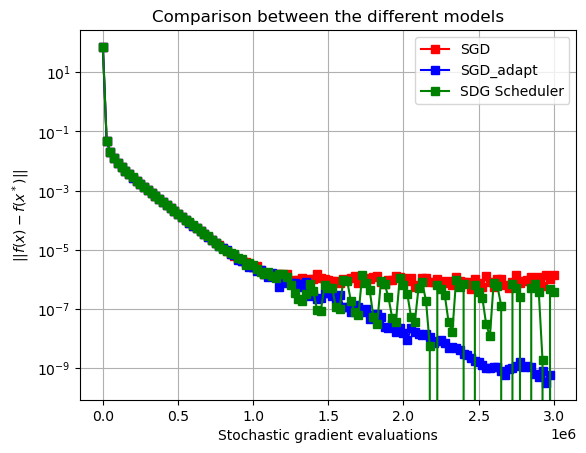

In [33]:
obj_functions = [obj_val_sgd, obj_val_sgd_adapt,obj_val_sgd_sched]
nb_gradients = [nb_comp_grad_sgd, nb_comp_grad_sgd_adapt,nb_comp_grad_sgd_sched]
name_of_models = ['SGD', 'SGD_adapt','SDG Scheduler']
list_times = [times1 , times2,times3]
plot_with_nb_gradients(nb_gradients=nb_gradients,obj_functions=obj_functions,name_of_models=name_of_models)

In [34]:
def plot_with_nb_gradients_bis(nb_gradients, obj_functions, name_of_models):
    """ 
    Plot the iterations of ||f(x) - f(x*)|| in function of the number 
    of gradienbts calculated.

    Args
    ----
    nb_gradients : for each row, number of gradients calculated at each iteration for each model
    obj_functions : array containing for each row all values of the objective 
                   function for one model at each iteration, and each row correponding 
                   to a model
    name_of_models : list containing the name of each model comprised in obj_functions
    """
    N = len(obj_functions)
    colors = ['red', 'blue', 'green', 'black', 'pink']
    final_value_f = 1

    for k in range(N):
        minimum =  min(obj_functions[k])
        if  minimum < final_value_f:
            final_value_f = minimum
    
    for k in range (N):
        plt.semilogy(nb_gradients[k], np.array(obj_functions[k]) - final_value_f, label=name_of_models[k], marker = 's', color=colors[k])
        plt.xlabel('Stochastic gradient evaluations')
        plt.ylabel(r"$||f(x) - f(x^*)||$")
        plt.title('Comparison between the different models')
        plt.legend()
        
    plt.grid()
    plt.show()

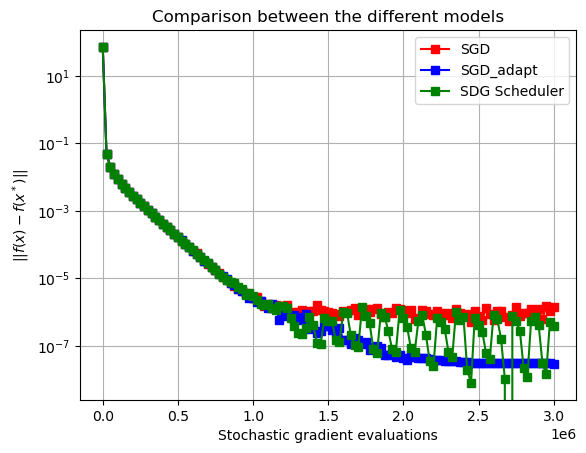

In [36]:
plot_with_nb_gradients_bis(nb_gradients=nb_gradients,obj_functions=obj_functions,name_of_models=name_of_models)

In [42]:
x_s2gd,obj_val_s2gd,_,nb_comp_grad_s2gd, times2 = S2GD(x0=x0,problem=pbL2reg,xtarget=x_model_truth,h=-1,m=10,nu=pbL2reg.cvxval(),eps_tol=1e-12,n_iter=20,plus=False)

h= 0.00409167248535782 m= 25402 n_iter= 28 delta= 0.37275937203149406
h= 0.00409167248535782 m= 25402 n_iter= 28 beta= 18548.67685578948
S2GD, n=25000. Exepcted number of inner loop at each iteration: 14100 in [12701,25402)
  iter   |   fval   |  normit  |    t    
       0 | 7.17e+01 | 7.41e+00 | 0.00e+00
       1 | 2.43e+01 | 4.61e+00 | 9.19e+03
       2 | 1.15e+01 | 3.13e+00 | 3.74e+03
       3 | 5.92e+00 | 2.58e+00 | 1.88e+03
       4 | 1.73e+00 | 1.21e+00 | 2.14e+04
       5 | 3.56e-01 | 6.27e-01 | 2.18e+04
       6 | 7.31e-02 | 3.13e-01 | 7.71e+03
       7 | 5.30e-02 | 1.93e-01 | 9.07e+03
       8 | 2.34e-02 | 1.08e-01 | 1.86e+04
       9 | 1.93e-02 | 8.47e-02 | 1.63e+04
      10 | 1.79e-02 | 6.23e-02 | 1.99e+04
      11 | 1.75e-02 | 5.72e-02 | 1.13e+04
      12 | 1.74e-02 | 5.23e-02 | 2.02e+04
      13 | 1.74e-02 | 5.08e-02 | 6.32e+03
      14 | 1.73e-02 | 4.96e-02 | 5.11e+03
      15 | 1.73e-02 | 4.89e-02 | 8.88e+03
      16 | 1.73e-02 | 4.85e-02 | 4.14e+03
      17 | 1.73e-02 

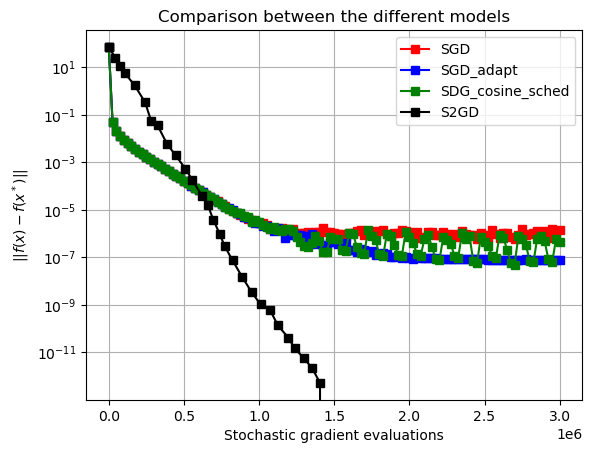

In [43]:
obj_functions = [obj_val_sgd, obj_val_sgd_adapt,obj_val_sgd_sched,obj_val_s2gd]
nb_gradients = [nb_comp_grad_sgd, nb_comp_grad_sgd_adapt,nb_comp_grad_sgd_sched,nb_comp_grad_s2gd]
name_of_models = ['SGD', 'SGD_adapt','SDG_cosine_sched','S2GD']
list_times = [times1 , times2,times3,times2]
plot_with_nb_gradients_bis(nb_gradients=nb_gradients,obj_functions=obj_functions,name_of_models=name_of_models)

In [89]:
from SAGA import SAGA
d = int(50)
n = int(100)
lbda = 1. / n ** (0.5)
#lbda = 0
kappa = 1e3

np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = generate_sparse_x(d,sparsity=0.1)

A, y = generate_pb_parameters(x_model_truth, n, d, kappa,lbda, std=0, corr=0.7)
ylog = np.sign(y) # Taking the logarithm for binary classification
yone = np.copy(ylog)
yone[ylog==-1] = 0 
x0 = np.random.randn(d)
pbL2reg = L2regLS(A,y,lbda,'l2')

print(pbL2reg.lipgrad())
x_saga, obj_val_saga, _, nb_comp_grad_saga, times4 = SAGA(x0=x0,problem=pbL2reg,xtarget=x_model_truth,gamma=2/(n*pbL2reg.lipgrad()),eps_tol=1e-12,n_iter=1e6,verbose=True,fast=True)

120.00000000000014
SAGA, n=100 with stepsize gamma = 0.00016666666666666647
  iter   |   fval   |  normit 
       0 | 9.47e+02 | 7.49e+00
     100 | 2.93e+02 | 5.74e+00
     200 | 1.42e+02 | 4.66e+00
     300 | 7.18e+01 | 4.09e+00
     400 | 4.04e+01 | 3.65e+00
     500 | 2.57e+01 | 3.39e+00
     600 | 1.94e+01 | 3.22e+00
     700 | 1.29e+01 | 3.07e+00
     800 | 9.59e+00 | 2.97e+00
     900 | 7.50e+00 | 2.88e+00
    1000 | 5.98e+00 | 2.82e+00
    1100 | 4.96e+00 | 2.76e+00
    1200 | 4.05e+00 | 2.71e+00
    1300 | 3.50e+00 | 2.67e+00
    1400 | 3.11e+00 | 2.63e+00
    1500 | 2.68e+00 | 2.60e+00
    1600 | 2.40e+00 | 2.57e+00
    1700 | 2.16e+00 | 2.55e+00
    1800 | 1.97e+00 | 2.53e+00
    1900 | 1.81e+00 | 2.50e+00
    2000 | 1.69e+00 | 2.49e+00
    2100 | 1.57e+00 | 2.47e+00
    2200 | 1.48e+00 | 2.45e+00
    2300 | 1.40e+00 | 2.43e+00
    2400 | 1.33e+00 | 2.42e+00
    2500 | 1.26e+00 | 2.40e+00
    2600 | 1.21e+00 | 2.39e+00
    2700 | 1.17e+00 | 2.38e+00
    2800 | 1.13e+00 | 2.3

In [75]:
x_s2gd,obj_val_s2gd,_,nb_comp_grad_s2gd, times2 = S2GD(x0=x0,problem=pbL2reg,xtarget=x_model_truth,h=-1,m=10,nu=pbL2reg.cvxval(),eps_tol=1e-12,n_iter=20,plus=False)

h= 0.0001677141938251133 m= 25402 n_iter= 28 delta= 0.37275937203149406
h= 0.0001677141938251133 m= 25402 n_iter= 28 beta= 18548.67685578948
S2GD, n=64. Exepcted number of inner loop at each iteration: 14100 in [12701,25402)
  iter   |   fval   |  normit  |    t    
       0 | 1.72e+03 | 7.56e+00 | 0.00e+00
       1 | 4.78e+02 | 4.40e+00 | 6.95e+02
       2 | 6.78e+01 | 1.65e+00 | 8.28e+03
       3 | 2.98e+01 | 9.32e-01 | 4.83e+03
       4 | 1.02e+01 | 5.92e-01 | 1.16e+04
       5 | 2.81e+00 | 3.33e-01 | 3.31e+03
       6 | 9.83e-01 | 1.57e-01 | 9.90e+03
       7 | 5.37e-01 | 9.98e-02 | 9.37e+03
       8 | 3.92e-01 | 5.43e-02 | 1.47e+04
       9 | 3.65e-01 | 4.39e-02 | 2.01e+04
      10 | 3.46e-01 | 4.13e-02 | 1.83e+04
      11 | 3.43e-01 | 3.89e-02 | 1.44e+04
      12 | 3.43e-01 | 3.91e-02 | 1.12e+04
      13 | 3.43e-01 | 3.90e-02 | 7.22e+03
      14 | 3.43e-01 | 3.88e-02 | 3.19e+03
      15 | 3.43e-01 | 3.88e-02 | 2.07e+03
      16 | 3.43e-01 | 3.88e-02 | 3.08e+03
      17 | 3.43e-01

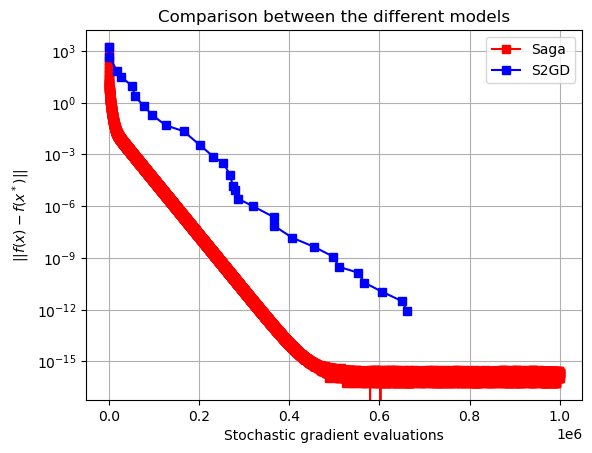

In [80]:
obj_functions = [obj_val_saga, obj_val_s2gd]
nb_gradients = [nb_comp_grad_saga, nb_comp_grad_s2gd]
name_of_models = ['Saga', 'S2GD']
list_times = [times1 , times2,times3,times2]
plot_with_nb_gradients_bis(nb_gradients=nb_gradients,obj_functions=obj_functions,name_of_models=name_of_models)